# Tests for the mpc module

PH July 2016

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import mpc
reload(mpc)

<module 'mpc' from 'mpc.pyc'>

In [3]:
r_th = 20
c_th= 0.02
r_th * c_th

0.4

In [4]:
dt = 0.1 #h
dyn = mpc.dyn_from_thermal(r_th, c_th, dt, "thermal subsys")

## Prediction matrices

In [5]:
n_hor = int(5/dt)
t = np.arange(1, n_hor+1)*dt
F, Hu, Hp = dyn.pred_mat(n_hor)

In [6]:
T0 = 20# °C
zn = np.zeros(n_hor)[:,None]
T_ext_hor = 2 + zn # °C
u_hor = 0 + zn # kW
u_max = 1.2 #kW
u_1 = 1.
u_hor[t>2.5] = u_1 

T_hor = np.dot(F, T0) + np.dot(Hu,u_hor) + np.dot(Hp, T_ext_hor)

In [7]:
T_hor.shape, np.dot(Hu,u_hor).shape, np.dot(Hp, T_ext_hor).shape

((50, 1), (50, 1), (50, 1))

In [8]:
#T_hor

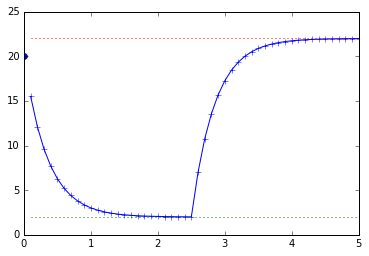

In [9]:
plt.plot(0, T0, 'bo')
plt.plot(t, T_hor, 'b-+')
plt.plot(t, T_ext_hor, 'g:')
plt.plot(t, T_ext_hor + u_1*r_th, 'r:')
plt.ylim(ymin=0);

Observations:

* without heating, $T → T_{ext}$
* with constant heating, $T → T_{ext} + R_{th}.u$

## Quadprog matrices

In [69]:
import cvxopt

In [70]:
ctrl = mpc.MPC(dyn, n_hor, 0, u_max, 1, 100)

Test the pred output method (based on prediction matrices)

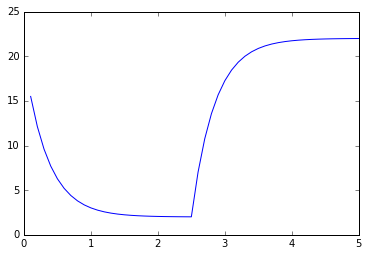

In [71]:
plt.plot(t, ctrl.pred_output(T0, u_hor, T_ext_hor))

### Matrices

In [72]:
P = ctrl.P
P.shape

(50, 50)

In [73]:
Ts_hor = 18 + zn # °C
Ts_hor[t>2.5] = 22 # °C

In [74]:
ctrl.set_xyp(T0, Ts_hor, T_ext_hor)

In [75]:
q = ctrl.q
q.shape

(50, 1)

In [76]:
G = ctrl.G
h = ctrl.h

In [77]:
qp = cvxopt.solvers.qp
matrix = cvxopt.matrix

#### Hand made call to cvxopt's qp

In [78]:
sol = qp(matrix(P), matrix(q), matrix(G), matrix(h))

In [79]:
u_opt = np.array(sol['x'])
u_opt.shape

(50, 1)

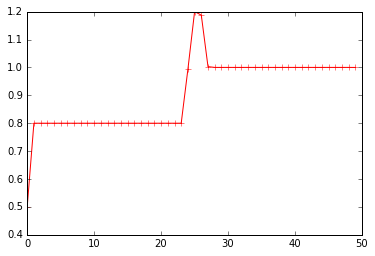

In [80]:
plt.plot(u_opt, 'r-+');

In [81]:
i_max = np.argmax(u_opt)
i_max

25

A look at slack and dual variables (cf. http://cvxopt.org/userguide/coneprog.html#quadratic-cone-programs)

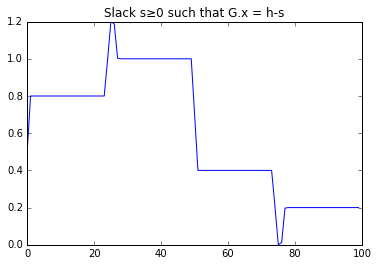

In [182]:
plt.plot(sol['s'])
plt.title(u'Slack s≥0 such that G.x = h-s');

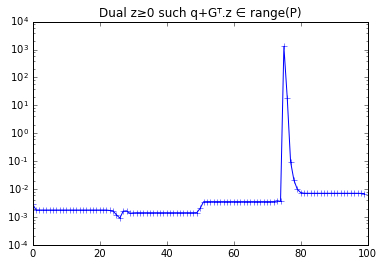

In [187]:
plt.semilogy(sol['z'], '-+')
plt.title(u'Dual z≥0 such q+Gᵀ.z ∈ range(P)');

#### Now with `solve_u_opt` method

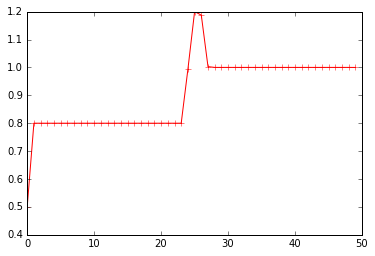

In [82]:
plt.plot(ctrl.solve_u_opt(), 'r-+');

Result on the temperature:

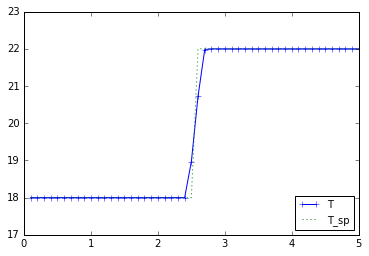

In [83]:
plt.plot(t, ctrl.pred_output(T0, u_opt, T_ext_hor), '+-', label='T')
plt.plot(t, Ts_hor, ':', label='T_sp');
plt.ylim(17, 23)
plt.legend(loc='lower right')

Changing u_cost

In [127]:
u_cost = np.zeros(n_hor)[:,None]
u_cost[24] = 500
u_cost[25] = 2500
u_cost[26] = 1000
ctrl.set_u_cost(1 + u_cost)

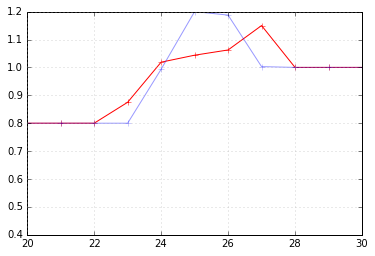

In [128]:
plt.plot(ctrl.solve_u_opt(), 'r-+');
plt.plot(u_opt, '-+', alpha=0.4);
plt.xlim(20, 30)
plt.grid(True)

Observation: by varying u_cost, it is indeed possible to reduce peak power

### Test of Uzawa:

adding the relaxation of the extra set of constraints [u(k)≤1.1]

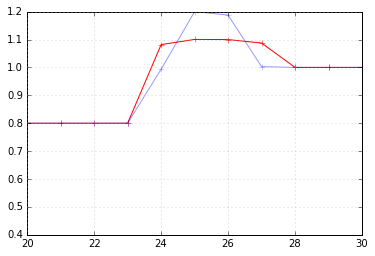

In [175]:
mult = np.zeros(n_hor)[:,None]
step = 4000
for k in range(31):
    ctrl.set_u_cost(1 + mult)
    u_opt_k = ctrl.solve_u_opt()
    u_diff = u_opt_k - 1.1
    mult += step*u_diff
    mult[mult<0] = 0

plt.plot(ctrl.solve_u_opt(), 'r-+');
plt.plot(u_opt, '-+', alpha=0.4);
plt.xlim(20, 30)
plt.grid(True)

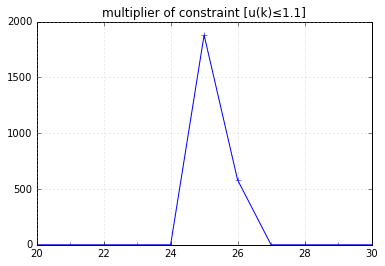

In [176]:
plt.plot(mult, '-+')
plt.xlim(20, 30)
plt.grid(True)
plt.title(u'multiplier of constraint [u(k)≤1.1]');

Compare with direct solution, by setting u_max=1.1

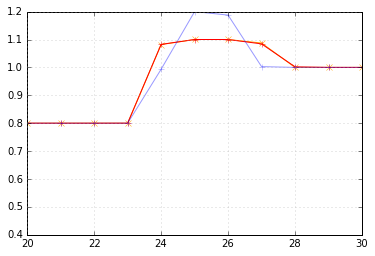

In [152]:
ctrl2 = mpc.MPC(dyn, n_hor, 0, 1.1, 1, 100)
ctrl2.set_xyp(T0, Ts_hor, T_ext_hor)

plt.plot(ctrl.solve_u_opt(), '-x', color='orange');
plt.plot(ctrl2.solve_u_opt(), 'r-+');
plt.plot(u_opt, '-+', alpha=0.4);
plt.xlim(20, 30)
plt.grid(True)

### Timing

In [22]:
n_hor

50

In [23]:
ctrl = mpc.MPC(dyn, n_hor, 0, u_max, 1, 100)

In [24]:
%timeit mpc.MPC(dyn, n_hor, 0, u_max, 1, 100)

100 loops, best of 3: 3.5 ms per loop


In [25]:
%timeit mpc.pred_mat(n_hor, dyn.A, dyn.C, dyn.Bu, dyn.Bp)

100 loops, best of 3: 3.26 ms per loop


In [26]:
%%timeit
ctrl._update_P()

The slowest run took 13.40 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 11.5 µs per loop


In [27]:
%%timeit
ctrl._update_Gh()

The slowest run took 12.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.4 µs per loop


In [28]:
%%timeit 
ctrl.set_xyp(T0, Ts_hor, T_ext_hor)

The slowest run took 20.90 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.09 µs per loop


In [29]:
%%timeit
cxP = matrix(P)
cxq = matrix(q)
cxG = matrix(G)
cxh = matrix(h)

100000 loops, best of 3: 19.2 µs per loop


In [30]:
cxP = matrix(P)
cxq = matrix(q)
cxG = matrix(G)
cxh = matrix(h)

Solve performance

In [31]:
cvxopt.solvers.options['show_progress'] = False

In [32]:
%timeit sol = qp(cxP, cxq, cxG, cxh)

1000 loops, best of 3: 1.32 ms per loop


In [33]:
sol

{'dual infeasibility': 3.1369672547350197e-16,
 'dual objective': -1508523.8248936045,
 'dual slack': 0.0009058447320722369,
 'gap': 0.3990380997833882,
 'iterations': 7,
 'primal infeasibility': 1.5877116567522106e-16,
 'primal objective': -1508523.4258555048,
 'primal slack': 2.369920547966732e-06,
 'relative gap': 2.645223089970168e-07,
 's': <100x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <50x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 'z': <100x1 matrix, tc='d'>}